In [1]:
import matplotlib.pyplot as plt
import fraud_detection.viz.model_plots as viz
from fraud_detection.data.loader import DataHandler
from fraud_detection.models.pipeline import build_pipeline
from fraud_detection.models.train import train_and_evaluate
from fraud_detection.core.settings import settings
import fraud_detection.models.compare as cp

In [2]:
# Test_original Data
test_original = DataHandler.from_registry(
    "DATA", "processed_dir", "test_original.parquet").load()

# Train_original Data
train_original = DataHandler.from_registry(
    "DATA", "processed_dir", "train_original.parquet").load()

# Train_resampled Data
train_resampled = DataHandler.from_registry(
    "DATA", "processed_dir", "train_resampled.parquet").load()

In [3]:
print("Train (original):", train_original.shape)
print("Train (resampled):", train_resampled.shape)
print("Test (original):", test_original.shape)

print("\nClass distribution (original train):")
print(train_original["class"].value_counts(normalize=True))

print("\nClass distribution (resampled train):")
print(train_resampled["class"].value_counts(normalize=True))

Train (original): (120889, 140)
Train (resampled): (219136, 140)
Test (original): (30223, 140)

Class distribution (original train):
class
0    0.906352
1    0.093648
Name: proportion, dtype: float64

Class distribution (resampled train):
class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [4]:
FEATURES = settings.get("features")

TARGET = FEATURES["target"]


X_train_orig = train_original.drop(columns=[TARGET])
y_train_orig = train_original[TARGET]

X_train_res = train_resampled.drop(columns=[TARGET])
y_train_res = train_resampled[TARGET]

X_test = test_original.drop(columns=[TARGET])
y_test = test_original[TARGET]

#### Training and Evalute on Original Data

In [5]:
results = {}
run_ids = {}
thresholds = {}
pipelines = {}


In [6]:
# -------------------------------
# Logistic Regression
# -------------------------------

profile_name = "ecommerce"
experiment_name = "fraud_detection_models"

baseline_models = {
    "Logistic Regression": {
        "pipeline": build_pipeline("logistic_regression"),
        "threshold_metric": "f1",
    },
}

for model_name, cfg in baseline_models.items():
    pipe, metrics, threshold, run_id = train_and_evaluate(
        pipeline=cfg["pipeline"],
        X_train=X_train_orig,
        y_train=y_train_orig,
        X_test=X_test,
        y_test=y_test,
        optimize_threshold=True,
        threshold_metric=cfg["threshold_metric"],
        model_name=model_name,
        profile_name=profile_name,
    )

    results[model_name] = metrics
    run_ids[model_name] = run_id
    thresholds[model_name] = threshold
    pipelines[model_name] = pipe

d:\10Acadamy\Week 5&6\Tasks\fraud-detection\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2025/12/28 17:48:50 INFO mlflow.tracking.fluent: Experiment with name 'fraud_detection_models' does not exist. Creating a new experiment.
2025/12/28 17:49:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
d:\10Acadamy\Week 5&6\Tasks\fraud-detection\.venv\Lib\site-packages\mlflow\tracking\_model_registry\utils.py:215: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will 

### Train and Evaluate on SMOTE Resampled Data

In [7]:

profile_name = "ecommerce"
experiment_name = "fraud_detection_models"

ensemble_models = {
    "Random Forest": {
        "pipeline": build_pipeline("random_forest"),
        "threshold_metric": "f1",
    },
    "XGBoost": {
        "pipeline": build_pipeline("xgboost"),
        "threshold_metric": "f1",
    },
}

for model_name, cfg in ensemble_models.items():
    pipe, metrics, threshold, run_id = train_and_evaluate(
        pipeline=cfg["pipeline"],
        X_train=X_train_res,
        y_train=y_train_res,
        X_test=X_test,
        y_test=y_test,
        optimize_threshold=True,
        threshold_metric=cfg["threshold_metric"],
        model_name=model_name,
        profile_name=profile_name,
    )

    results[model_name] = metrics
    run_ids[model_name] = run_id
    thresholds[model_name] = threshold
    pipelines[model_name] = pipe

2025/12/28 17:54:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'ecommerce_model' already exists. Creating a new version of this model...
Created version '2' of model 'ecommerce_model'.
2025/12/28 17:57:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'ecommerce_model' already exists. Creating a new version of this model...
Created version '3' of model 'ecommerce_model'.


In [8]:
scored_df = cp.score_models(
    results=results,
    profile_name=profile_name,
)

print(scored_df)

                     performance_score  cost_score   total_score
model                                                           
XGBoost                       0.749409      -19805 -19804.250591
Logistic Regression           0.700306      -20910 -20909.299694
Random Forest                 0.633260      -21485 -21484.366740


In [9]:
best_model, best_metrics, reason = cp.select_best_model(
    results=results,
    profile_name=profile_name,
)

print(reason)

Selected 'XGBoost' because it achieved the highest total_score (-19804.2506) under the 'ecommerce' business profile.


In [10]:
best_run_id = run_ids[best_model]

promotion_result = cp.promote_best_model(
    profile_name=profile_name,
    run_id=best_run_id,
)

print(f"{best_model} promoted to Production:", promotion_result)

XGBoost promoted to Production: No Production model found. Promoted first model.


D:\10Acadamy\Week 5&6\Tasks\fraud-detection\src\fraud_detection\models\compare.py:189: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


In [11]:
best_run_id = run_ids[best_model]

promotion_result = cp.promote_best_model(
    profile_name="ecommerce",
    run_id=best_run_id,
)

print(f"{best_model} promoted to Production:", promotion_result)

XGBoost promoted to Production: New model did not outperform Production. No promotion.


In [12]:
predictions = {}

for model_name, pipe in pipelines.items():
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= thresholds[model_name]).astype(int)

    predictions[model_name] = {
        "y_pred": y_pred,
        "y_proba": y_proba,
    }


=== Logistic Regression ===


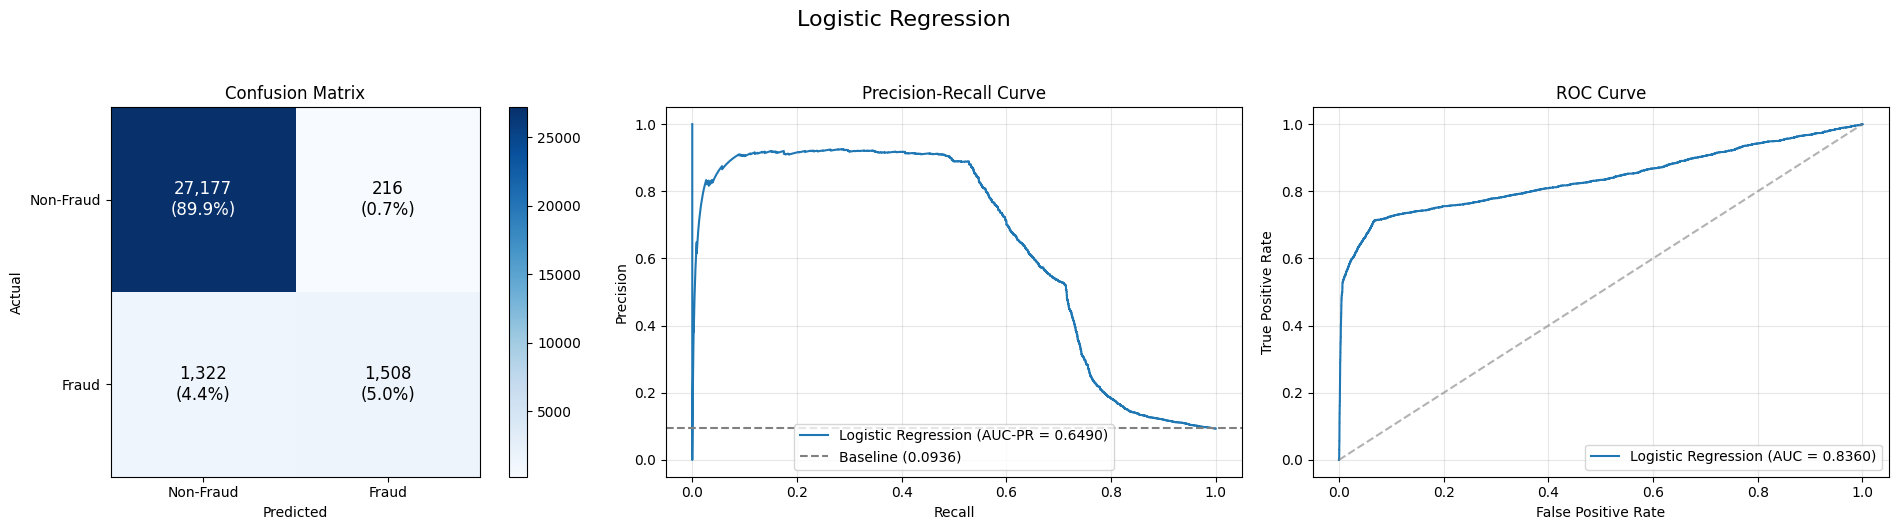

              precision    recall  f1-score       support
Non-Fraud      0.953612  0.992115  0.972483  27393.000000
Fraud          0.874710  0.532862  0.662275   2830.000000
accuracy       0.949112  0.949112  0.949112      0.949112
macro avg      0.914161  0.762488  0.817379  30223.000000
weighted avg   0.946224  0.949112  0.943436  30223.000000

=== Random Forest ===


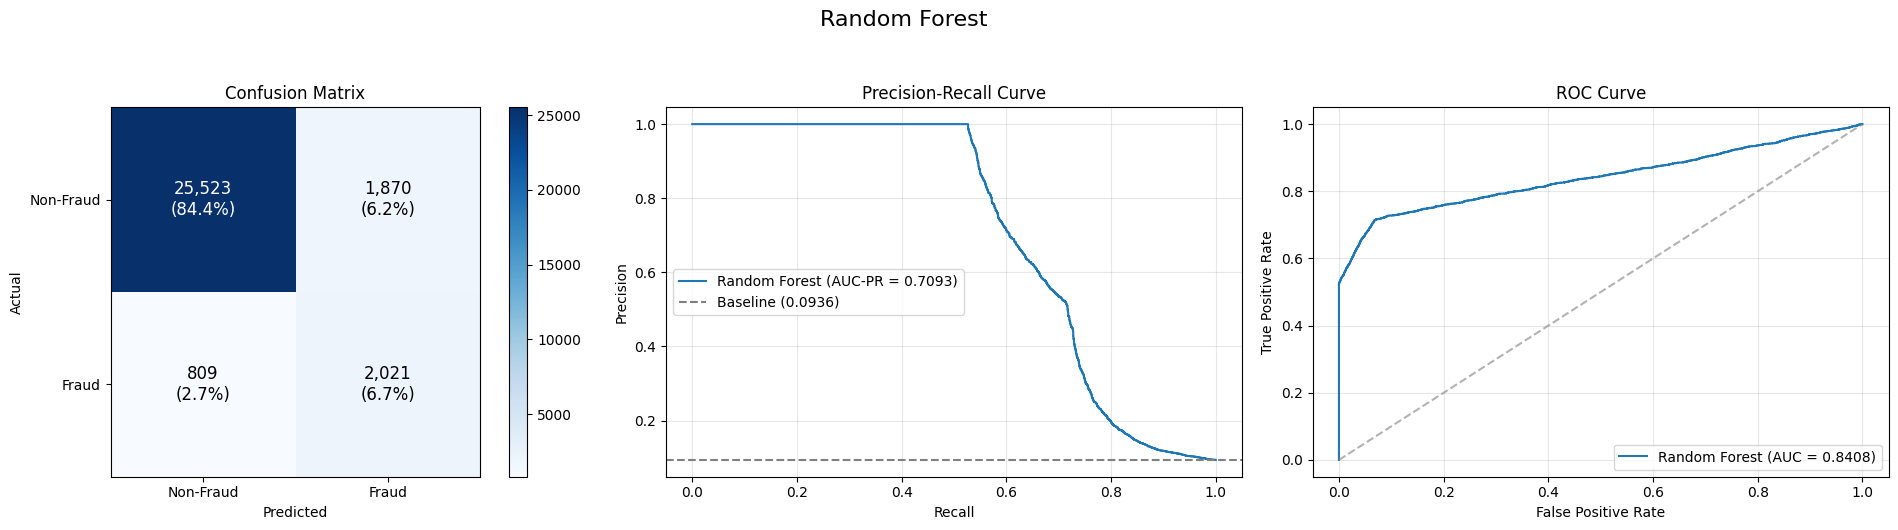

              precision    recall  f1-score       support
Non-Fraud      0.969277  0.931734  0.950135  27393.000000
Fraud          0.519404  0.714134  0.601399   2830.000000
accuracy       0.911359  0.911359  0.911359      0.911359
macro avg      0.744340  0.822934  0.775767  30223.000000
weighted avg   0.927152  0.911359  0.917480  30223.000000

=== XGBoost ===


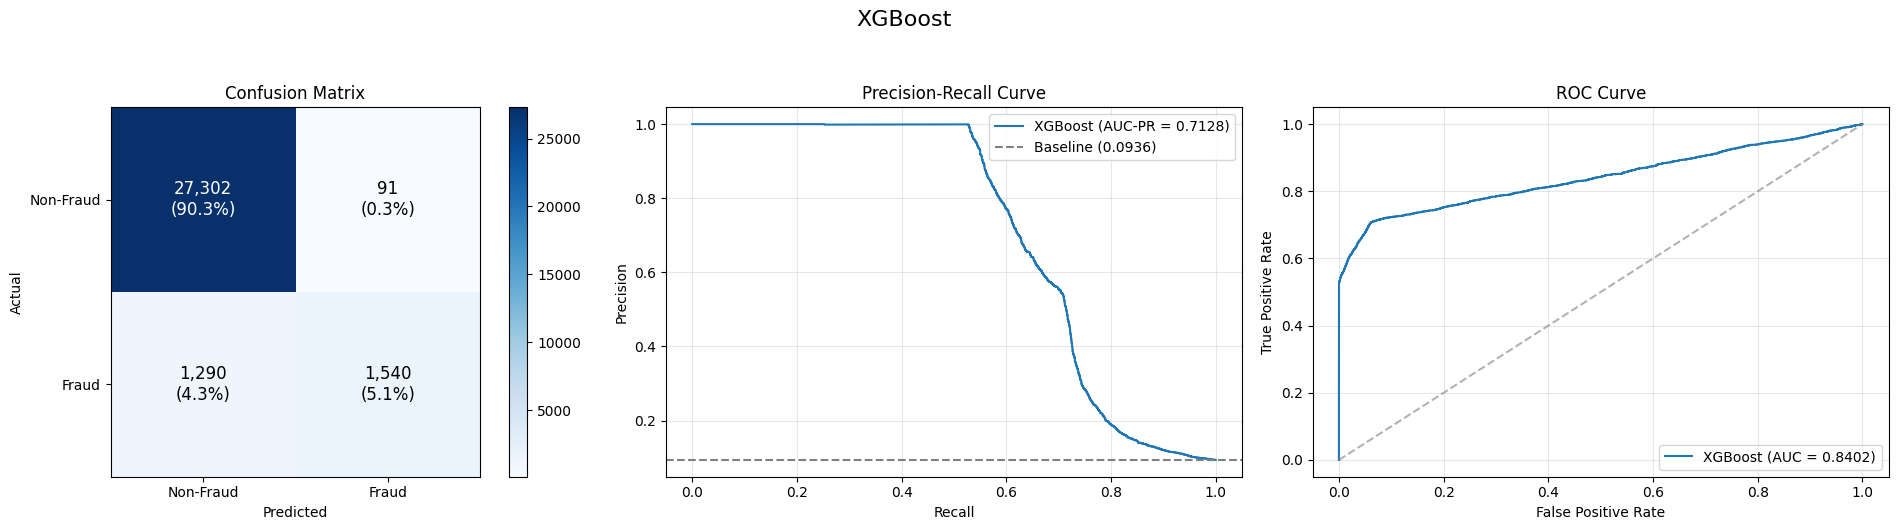

              precision    recall  f1-score       support
Non-Fraud      0.954882  0.996678  0.975333  27393.000000
Fraud          0.944206  0.544170  0.690428   2830.000000
accuracy       0.954306  0.954306  0.954306      0.954306
macro avg      0.949544  0.770424  0.832880  30223.000000
weighted avg   0.953883  0.954306  0.948655  30223.000000


In [13]:
for model_name, data in predictions.items():
    y_pred = data["y_pred"]
    y_proba = data["y_proba"]

    print(f"\n=== {model_name} ===")

    fig, axes = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(20, 5),
    )

    # 1️⃣ Confusion Matrix
    viz.plot_confusion_matrix(
        y_true=y_test.values,
        y_pred=y_pred,
        title="Confusion Matrix",
        ax=axes[0],
    )

    # 2️⃣ Precision–Recall Curve
    viz.plot_precision_recall_curve(
        y_true=y_test.values,
        y_proba=y_proba,
        model_name=model_name,
        ax=axes[1],
    )

    # 3️⃣ ROC Curve
    viz.plot_roc_curve(
        y_true=y_test.values,
        y_proba=y_proba,
        model_name=model_name,
        ax=axes[2],
    )

    fig.suptitle(model_name, fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

    # 4️⃣ Classification Report
    report_df = viz.get_classification_report_df(
        y_true=y_test.values,
        y_pred=y_pred,
    )
    print(report_df)